# resample: bootstrap and jackknife resampling in Python

- Hans Dembinski, TU Dortmund, contributor & presenter
- Daniel Saxton @dsaxton, creator of *resample* module in Python

PyPI          | https://pypi.org/project/resample
--------------|:----------------------------------
Code          | https://github.com/dsaxton/resample
Documentation | https://resample.readthedocs.io

**Disclaimer:** Shown here is a not-yet-released development version of *resample* (prototype for version 1.0 with re-designed interface).

**References**
* B. Efron, R.J. Tibshirani (1993), *An Introduction to the Bootstrap*, Chapman & Hall/CRC, ISBN 0-412-04231-2
* A. C. Davison, D. V. Hinkley (1997), *Bootstrap Methods and Their Application*, Cambridge University Press, ISBN 0-521-57471-4
* Bradley Efron (1979), *Bootstrap methods: Another look at the jackknife*, Annals of Statistics 7: 1–26. doi:10.1214/aos/1176344552.
* [Jackknife on Wikipedia](https://en.wikipedia.org/wiki/Jackknife_resampling)
* [Empirical distribution function on Wikipedia](https://en.wikipedia.org/wiki/Empirical_distribution_function)

In [1]:
import numpy as np
import resample.jackknife
import resample.bootstrap
import matplotlib.pyplot as plt

## Introduction

* Resampling methods are general purpose tools to obtain standard deviations, biases, confidence intervals of statistical estimates, hypothesis testing
    * Jackknife
        - Developed by Maurice Quenouille in 1950ies
        - Expanded and popularized by John Tukey 1958
        - Deterministic
    * Bootstrap
        - Developed by Bradley Efron in 1979
        - Non-deterministic (uses random sampling)

### Pros
* Incredibly easy to use: same formulas for large classes of problems
* Wide applicability and particularly suited for HEP
* Theoretically well understood and mature, various proven properties
* Works with arbitrarily complex estimators (median, resampling itself, ...)
* No parametric model of data required (but can be included to improve accuracy)
* Avoids case-dependent mathematical treatment ("one size fits all")
* Avoids common approximations only valid in asymptotic limit (but see below)
* Computation perfect for parallelization

### Cons
* Computationally expensive: requires 100 to 1000 applications of the original estimator
    * Trades computation time against developer time (we usually consider that good)
    * Not well suited for unbinned analyses with millions of data points (but data can be binned)
* Need to be able to split data into independent and identically distributed (*i.i.d.*) observations
    - Time series cannot be handled naturally (but approximations exist)
    - Applications in HEP may require some care (e.g. resampling whole events instead of tracks)
* Only holds exactly in asymptotic limit; approximation error is computable, but expensive
* Unexpected bumps may be encountered on the road when using a new tool

## Definitions

Symbol        | Description
------------- | :-----------
$F$           | Cumulative density function 
$\mathbf x$   | Sample of observations
$\theta$      | Parameter of interest of distribution
$\hat \theta$ | Estimate of $\theta$ from some sample $\mathbf x$
$s(\mathbf x)$| Function which computes $\hat\theta$ from sample $\mathbf x$ (can be any function implementable on a computer, e.g. a fit)

## Jackknife

* Compute estimate $\hat\theta = s(\mathbf{x})$ from original sample
* For all $i$: leave $i$-th observation out and apply $s$ on remaining sample $\mathbf x_{(i)}$ to obtain estimate $\hat \theta_{(i)}$


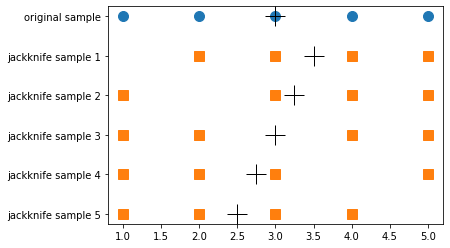

In [2]:
data = np.arange(1, 6)

plt.plot(data, np.zeros_like(data), "o", ms=10)
plt.plot(np.mean(data), 0, "+k", ms=20)

for i, jd in enumerate(resample.jackknife.resample(data)):
    plt.plot(jd, -i - 1 + np.zeros_like(jd), "s", ms=10, color="C1")
    plt.plot(np.mean(jd), -i - 1, "+k", ms=20)

plt.yticks(-np.arange(0, 6),
           ["original sample"] + [f"jackknife sample {i}" for i in range(1, 6)]);

Bias and variance of $\hat\theta$ can be computed from $\hat\theta_{(i)}$, using this definition
$$
\hat \theta_{(.)} \equiv \langle \hat\theta_{(i)} \rangle = \frac{1}{n} \sum_i \hat \theta_{(i)}
$$
we get
* jackknife bias
  $$
  \widehat{\text{bias}}_{\hat \theta} = (n - 1) (\hat\theta_{(.)} - \hat \theta)
  $$

* jackknife variance
  $$
  \widehat{\text{var}}_{\hat \theta} = \frac{(n-1)}{n} \sum_i \big(\hat\theta_{(i)} - \hat\theta_{(.)}\big)^2
  $$
  
Let's try them on a three estimators.

In [3]:
rng = np.random.default_rng(1)

n_sample = 100
x = rng.exponential(size=n_sample)

estimators = {
    "mean": np.mean,
    "median": np.median,
    # intentionally use biased variance estimator
    "var": lambda x: np.mean((x - np.mean(x)) ** 2)
}

print("sample values")
for name, est in estimators.items():
    v = est(x)
    print(f"  {name:10} = {v:.3f}")

print("jacknifed biases")
for name, est in estimators.items():
    v = resample.jackknife.bias(est, x)
    print(f"  {name:10} = {v:.3f}")
print("exact bias of var = -1/(n-1) * var = "
      f"{-1/(n_sample-1) * estimators['var'](x):.3f}")

sample values
  mean       = 1.038
  median     = 0.687
  var        = 1.541
jacknifed biases
  mean       = 0.000
  median     = 0.000
  var        = -0.016
exact bias of var = -1/(n-1) * var = -0.016


* We used the naive variance estimator here:
$$
\widehat{\text{var}} = \frac{1}{n} \sum_i (x_i - \bar x)^2
$$

* Bias-corrected variance estimator is known to be:
$$
\widehat{\text{var}}_{bc} = \frac{1}{n-1} \sum_i (x_i - \bar x)^2
$$

* Exact bias is:
$$
\widehat{\text{var}} - \widehat{\text{var}}_{bc} = \left(\frac{1}{n} - \frac{1}{n-1}\right) n \, \widehat{\text{var}} = \left(\frac{n-1}{n (n-1)} - \frac{n}{n(n-1)}\right) n \, \widehat{\text{var}} = -\frac{1}{n-1}\widehat{\text{var}}
$$

The jackknife has correctly estimated the bias for all three estimators to 3 digits.

Let's see how well it does for variances.

In [4]:
def variance_of_mean(x):
    n = len(x)
    return np.var(x) / n


def variance_of_median(x):
    # see https://en.wikipedia.org/wiki/Median, original derivation by Laplace
    mu = np.mean(x)
    m = np.median(x)
    # value of exponential density for this sample at median
    fm = 1/mu * np.exp(-m / mu)
    n = len(x)
    return 1/(4 * n * fm ** 2)


def variance_of_variance(x):
    # see https://en.wikipedia.org/wiki/Variance#Distribution_of_the_sample_variance
    n = len(x)
    u = np.mean(x)
    s = np.std(x)
    u4 = np.mean((x - u)**4)
    return (u4 - s ** 4 * (n - 3) / (n - 1)) / n

In [5]:
print("jackknife'd std. deviations of estimators")
for name, est in estimators.items():
    v = resample.jackknife.variance(est, x) ** 0.5
    print(f"  {name:10} = {v:.3f}")

print(f"textbook std. deviation of mean   = {variance_of_mean(x) ** 0.5:.3f}")
print(f"textbook std. deviation of median = {variance_of_median(x) ** 0.5:.3f}")
print(f"textbook std. deviation of var    = {variance_of_variance(x) ** 0.5:.3f}")

jackknife'd std. deviations of estimators
  mean       = 0.125
  median     = 0.013
  var        = 0.615
textbook std. deviation of mean   = 0.124
textbook std. deviation of median = 0.101
textbook std. deviation of var    = 0.606


The jackknife estimates are very good for the standard deviation of the mean and the variance, but not for the median.

The underestimation for the median is a consequence of the lack of smoothness in the median, in the following sense: a small change in $x_i$ causes a small change in $\hat \theta = s(\mathbf x)$. Taking one value out of the sample at a time sometimes creates zero variation in the estimator.


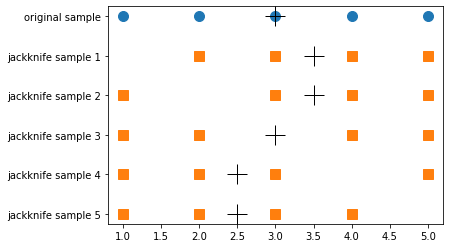

In [6]:
rng = np.random.default_rng(2)

data = np.arange(1, 6)

plt.plot(data, np.zeros_like(data), "o", ms=10)
plt.plot(np.median(data), 0, "+k", ms=20)

for i, jd in enumerate(resample.jackknife.resample(data)):
    plt.plot(jd, -i - 1 + np.zeros_like(jd), "s", ms=10, color="C1")
    plt.plot(np.median(jd), -i - 1, "+k", ms=20)

plt.yticks(-np.arange(0, 6), ["original sample"] +
           [f"jackknife sample {i}" for i in range(1, 6)]);

Prefer the bootstrap for estimating bias and variance of robust estimators like the median.

**Note how easily results are obtained with the jackknife, which would require exotic formulas otherwise!**

### Summary: Jackknife

* Deterministic linear approximation to bootstrap
* Small computational cost for small data sets ($n < 100$), bootstrap better for larger sets
* Can be used to compute bias & variance of arbitrary "smooth" estimators
* Good results even for small samples
* Fails for "non-smooth" estimators
 * Example: median
 * Fixed in generalized jackknife which deletes $d>1$ points (not discussed here)

## Bootstrap

### Empirical CDF

* If CDF $F$ was known, we could compute any finite sample properties of an estimator $s(\mathbf x)$ by Monte-Carlo simulation
    * Draw sample $\mathbf x$ from $F$, compute $s(\mathbf x)$, repeat
    * Build full distribution of $\hat \theta$
    * Compute bias, variance, confidence intervals, etc.
* Observation: If nothing else is known about $F$, then sample $\mathbf x$ contains all available information about $F$
* Idea (plug-in principle)
  * Replace $F$ by empirical CDF $\hat F$
  $$
  \hat F(x) = \frac{\text{number of elements in sample }\le x}{n} = \frac{1}{n} \sum_i H(x - x_i) \; \text{ (Heaviside function)} 
  $$
* Proven properties of $\hat F$
  * Maximum-likelihood estimate of $F$ in absence of other information
  * Consistent: $\lim_{n\rightarrow \infty}\hat F = F$
  * $\hat F$ appoaches $F$ uniformly (stronger statement than consistency)

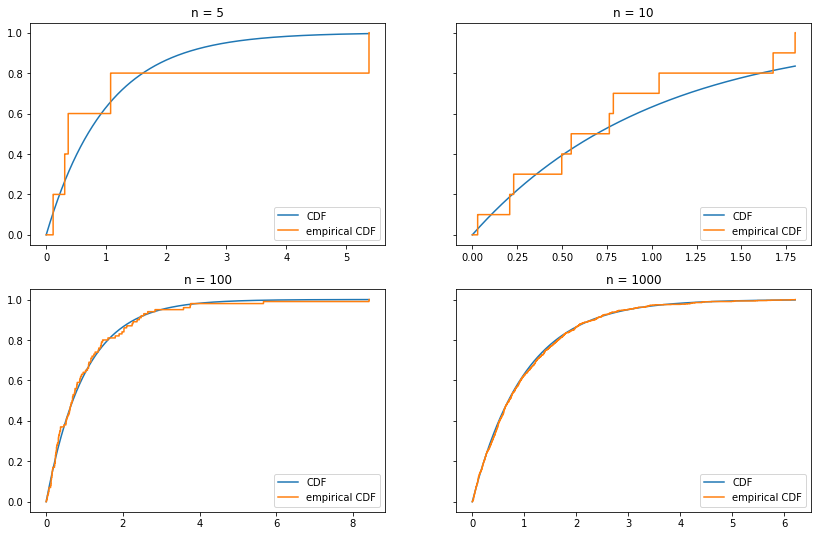

In [7]:
rng = np.random.default_rng(1)

fig, ax = plt.subplots(2, 2, figsize=(14, 9), sharey=True)
for n, axi in zip((5, 10, 100, 1000), ax.flat):
    x = rng.exponential(size=n)

    cdf = resample.empirical.cdf_fn(x)

    def expon_cdf(x):
        return 1 - np.exp(-x)

    plt.sca(axi)
    plt.title(f"n = {n}")
    xm = np.linspace(0, np.max(x), 10000)
    plt.plot(xm, expon_cdf(xm), label="CDF")
    plt.plot(xm, resample.empirical.cdf_fn(x)(xm),
             drawstyle="steps", label="empirical CDF")
    plt.legend(loc="lower right")

The empirical CDF approaches true CDF as number of samples increases.

### Bootstrap: Sample from empirical CDF

* Empirical CDF is an approximation to true CDf
* Infer properties of $\hat\theta$ by sampling from $\hat F$ (bootstrapping)
* Equivalent to sampling from original data with replacement


In [8]:
def hist(x, offset, **kwargs):
    ws, xedges = np.histogram(x)

    m = len(ws)
    n = 2 * m + 2

    xy = np.zeros((2, n))

    xy[0][0] = xedges[0]
    xy[0][-1] = xedges[-1]

    for i in range(m):
        xy[0][1 + 2 * i] = xedges[i]
        xy[1][1 + 2 * i] = ws[i]
        xy[0][1 + 2 * i + 1] = xedges[i + 1]
        xy[1][1 + 2 * i + 1] = ws[i]

    x, y = xy
    return plt.gca().fill_between(x, offset, y + offset, **kwargs)

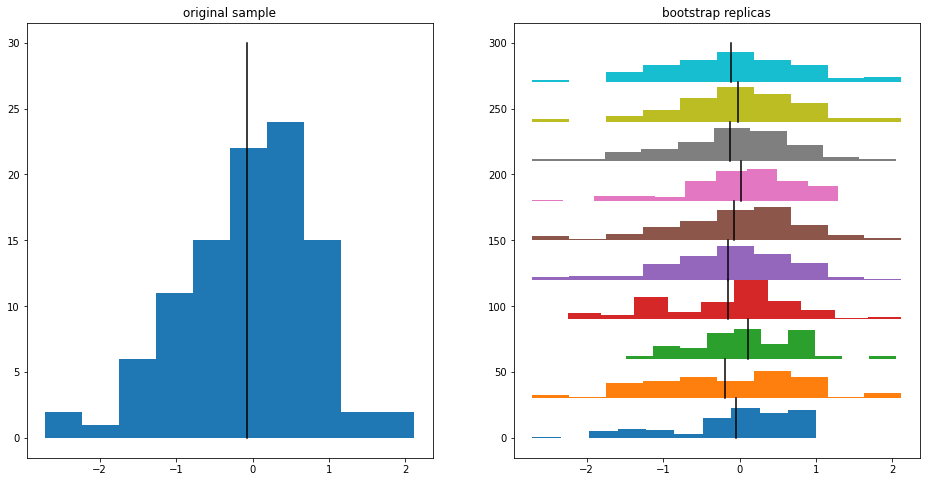

In [9]:
rng = np.random.default_rng(1)

x = rng.normal(size=100)

fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
plt.sca(ax[0])
plt.title("original sample")
hist(x, 0)
plt.plot(np.mean(x) * np.ones(2), [0, 30], color="k")

plt.sca(ax[1])
plt.title("bootstrap replicas")
for i, replica in enumerate(resample.bootstrap.resample(x, size=10, random_state=rng)):
    hist(replica, 30 * i)
    plt.plot(np.mean(replica) * np.ones(2), [30 * i, 30 * (i + 1)], color="k")

* Bootstrap not deterministic: uses samples generated from pseudo-random number generator and original data
    * Seed of RNG can be fixed to get reproducible results
* Accuracy can be traded against computation time by increasing number of bootstrapped samples

Let's repeat the study of bias and variance of several estimators with the bootstrap.

In [10]:
rng = np.random.default_rng(1)

n_sample = 100
x = rng.exponential(size=n_sample)

estimators = {
    "mean": np.mean,
    "median": np.median,
    # intentionally use biased variance estimator
    "var": lambda x: np.mean((x - np.mean(x)) ** 2)
}

print("sample values")
for name, est in estimators.items():
    v = est(x)
    print(f"  {name:10} = {v:.3f}") 

print("bootstrapped biases with 10 replicas")
for name, est in estimators.items():
    v = resample.bootstrap.bias(est, x, size=10, random_state=rng)
    print(f"  {name:10} = {v:.3f}")


print("bootstrapped biases with 1000 replicas")
for name, est in estimators.items():
    v = resample.bootstrap.bias(est, x, size=1000, random_state=rng)
    print(f"  {name:10} = {v:.3f}")
    
print(f"exact bias of var = -1/(n-1) * var = {-1/(n_sample-1) * estimators['var'](x):.3f}")

sample values
  mean       = 1.038
  median     = 0.687
  var        = 1.541
bootstrapped biases with 10 replicas
  mean       = 0.000
  median     = 0.005
  var        = -0.008
bootstrapped biases with 1000 replicas
  mean       = 0.000
  median     = 0.000
  var        = -0.015
exact bias of var = -1/(n-1) * var = -0.016


Again, the bias is very well estimated.

In [11]:
rng = np.random.default_rng(1)

print("bootstrapped std. deviations of estimators")
for name, est in estimators.items():
    v = resample.bootstrap.variance(est, x, size=2000, random_state=rng) ** 0.5
    print(f"  {name:10} = {v:.3f}")

print(f"textbook std. deviation of mean   = {variance_of_mean(x) ** 0.5:.3f}")
print(f"textbook std. deviation of median = {variance_of_median(x) ** 0.5:.3f}")
print(f"textbook std. deviation of var    = {variance_of_variance(x) ** 0.5:.3f}")

bootstrapped std. deviations of estimators
  mean       = 0.126
  median     = 0.080
  var        = 0.600
textbook std. deviation of mean   = 0.124
textbook std. deviation of median = 0.101
textbook std. deviation of var    = 0.606


The uncertainties are all very close to the textbook estimates, including the uncertainty of the median!

We can also compute confidence intervals. The library includes three methods.

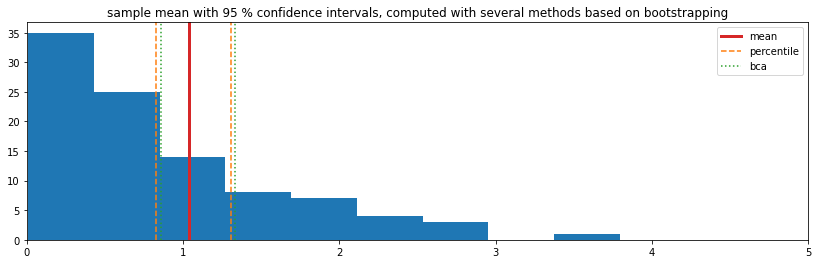

In [12]:
rng = np.random.default_rng(1)

plt.figure(figsize=(14, 4))

plt.hist(x, bins=20)

plt.axvline(np.mean(x), color="C3", lw=3, label="mean")

for i, ci_method in enumerate(("percentile", "bca")):
    ci = resample.bootstrap.confidence_interval(np.mean, x,
                                                ci_method=ci_method, random_state=rng)
    for cii in ci:
        plt.axvline(cii, ls=["--", ":", "-."][i], color=f"C{i+1}",
                    label=ci_method if cii is ci[0] else None)

plt.xlim(0, 5)
plt.title("sample mean with 95 % confidence intervals, "
          "computed with several methods based on bootstrapping")
plt.legend();

Confidence interval computation methods in order of increasing sophistication:
* percentile: straight-forward quantiles of the replicated $\hat\theta_i$
* bca: Stands for bias-corrected and accelerated
  * Corrects biases of order $O(1/n)$ in quantiles (2nd order accurate)
  * Transformation invariant


### Summary: Bootstrap

* Non-deterministic resampling method
    * Non-parametric or
    * Parametric
* Computational cost is $O(n  k)$ with sample size $n$ and $k$ replicated samples
* Accuracy can be traded against computation time
    * Good for prototyping
* May be less expensive than jackknife for large data sets ($n > 100$)
* Can be used to compute bias & variance of arbitrary estimators
    * Including non-smooth ones (e.g. median)
* Good results even for small samples
* Non-parametric bootstrap fails for estimators very sensitive to tails
    * Use parametric bootstrap in this case
    * 95 % intervals ok, but 5 sigma intervals?
      https://abload.de/img/house-shrugh0seu.gif


## Uncertainties of resampling estimates

* In applications: need to know accuracy of bootstrap/jackknife estimates
    * We usually do not care about uncertainties of uncertainties
    * But we care about uncertainty of a bias estimate
* Resampling uncertainty (only bootstrap, does not apply to jackknife)
    * Can be made negligible by increasing $k$, number of replicated samples
    * $\text{var} \propto 1/k$
        * 10% for $k=100$
        * 3% for $k=1000$
    * Can be empirically assessed by re-calculating a few times
* Uncertainty from approximating $F$ by $\hat F$ (valid for bootstrap and jackknife)
    * Estimate again with resampling: second-order jackknife or bootstrap
        * Double bootstrap
        * Jackknife-after-bootstrap
        
Let's use the Jackknife-after-bootstrap to estimate accuracy of standard deviation of the median estimated with the bootstrap.

In [13]:
rng = np.random.default_rng(1)

data = rng.exponential(size=100)


def bootstrapped_std(sample, size):
    return resample.bootstrap.variance(np.median, sample, size=size) ** 0.5


n = np.array((10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000))
y = []
ye = []
for size in n:
    v = bootstrapped_std(data, size)
    s = resample.jackknife.variance(
        lambda d: bootstrapped_std(d, size), data) ** 0.5
    print(f"size = {size:4}: median std = {v:.3f} +- {s:.3f}")
    y.append(v)
    ye.append(s)

size =   10: median std = 0.076 +- 0.228
size =   20: median std = 0.091 +- 0.136
size =   30: median std = 0.084 +- 0.107
size =   40: median std = 0.077 +- 0.110
size =   50: median std = 0.078 +- 0.096
size =  100: median std = 0.080 +- 0.067
size =  200: median std = 0.081 +- 0.051
size =  300: median std = 0.074 +- 0.045
size =  400: median std = 0.078 +- 0.038
size =  500: median std = 0.075 +- 0.037
size = 1000: median std = 0.074 +- 0.028


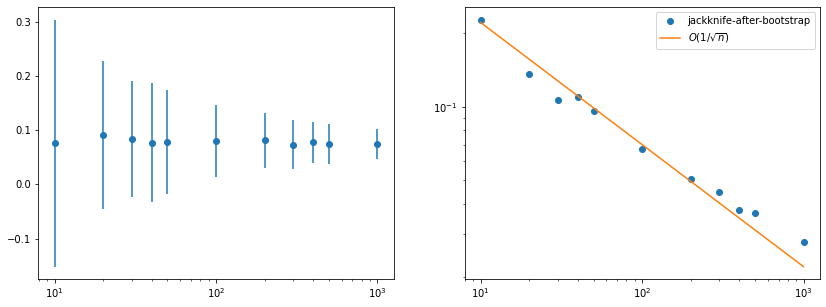

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plt.sca(ax[0])
plt.errorbar(n, y, ye, fmt="o")
plt.semilogx()
plt.sca(ax[1])
plt.plot(n, ye, "o", label="jackknife-after-bootstrap")
plt.plot(n, 0.7 * n ** -0.5, label=r"$O(1/\sqrt{n})$")
plt.legend()
plt.loglog();

The jackknife correctly captures the expected $1/\sqrt{n_\text{replicas}}$ evolution of the bootstrap uncertainty, but overestimates the scale of variation of the bootstrap estimate. Needs further investigation.

## Not covered

* parametric bootstrap: it is easy, just use e.g. `resample.bootstrap.resample(sample, method="normal")`
* `resample.permutation` Hypothesis testing based on (random) data permutation

## Roadmap for resample-1.0.0

* Interface overhaul (nearly complete)
* Adding documentation (ongoing)
* Adding more tests (ongoing)
  * bootstrap and jackknife already exhaustively tested